In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)



/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# pulling the data with sessions info and the data with gcamp together. 
data = pd.read_csv('./data/rachel_table.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session'])

data_g = pd.read_csv('./data/dan_table.csv')

data['gcamp'] = data_g['gcamp']

data = data[(data['RecordLoc'] != 5) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [3]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        trial_df = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(trial_df.IpsLeverPress.values) >  sum(trial_df.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(trial_df.CSplus.values) >  sum(trial_df.CSneg.values):
            reward = 1
        else:
            reward = 0

        sess = np.unique(trial_df['Session'])[0]
        recordloc = np.unique(trial_df['RecordLoc'])[0]
        data_t.append([ mouse_id - 1, t_i, action, reward, t , sess, recordloc]) #  lever_press])

  

In [4]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'TrialStart',
                                             'Session', 'RecordLoc'))
                


In [5]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

# gcamp

In [6]:
data_DMS = data[(data['RecordLoc'] == 1) ]


In [7]:
# normalize

def normalize(x, mu, std):
    return (x - mu) / std

for mouse_id in np.unique(data_DMS['MouseID']):
    mice_gcamp = data_DMS.loc[data_DMS['MouseID'] == mouse_id, 'gcamp'].values
    mice_mu = (np.mean(mice_gcamp))
    mice_std = (np.std(mice_gcamp))
    
    data_DMS.loc[data_DMS['MouseID'] == mouse_id, 'gcamp'] = normalize(mice_gcamp, mice_mu, mice_std)

    

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
%%time
# pull out trial by trial info 

data_g = []

dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
        

for mouse_id in np.unique(data['MouseID']):
    data_small = data_DMS[data_DMS['MouseID'] == mouse_id]


    trial_starts = np.where(data_small['TrialStart'] == 1)[0]

    
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):
        



        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        data_trial = data_small[t:trial_end];
        
        # get gcamp after nose poke enter and before lever press 
        npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
        lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]
        gcamp_pre_lever = data_trial['gcamp'].values[npe_i:lp_i]
        


        
        # check choice and record time between lever and choice 
        if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
            action = 'Ips'
            choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
        else:
            action = 'Con'
            choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]
        gcamp_pre_choice = data_small['gcamp'].values[lp_i:choice_i]
        
        
        # check if mice is rewarded 
        if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
            reward = 1
            reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
            reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:reward_end_i]
        else:
            reward = 0
            reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:trial_end]
        delay = reward_i - choice_i
        
        # get timelocked gcamp to nose-poke
        

        tstart_i_by_np = (npe_i - LEN_BEFORE)
        gcamp_np = data_small['gcamp'].values[(t + npe_i - LEN_BEFORE): (t + npe_i + LEN_AFTER)]
        

        
        # get timelocked gcamp to lp 
 
        np_i_by_lp = (npe_i - (lp_i - LEN_BEFORE))
        gcamp_lp = data_small['gcamp'].values[(t + lp_i - LEN_BEFORE): (t + lp_i + LEN_AFTER)]
        
        
        # get timelocked gcamp to choice

        lp_i_by_choice = lp_i - (choice_i - LEN_BEFORE)
        gcamp_choice = data_small['gcamp'].values[(t + choice_i - LEN_BEFORE): (t + choice_i + LEN_AFTER)]



        choice_i_by_reward = (choice_i - (reward_i - LEN_BEFORE))
        gcamp_reward = data_small['gcamp'].values[(t + reward_i - LEN_BEFORE): (t + reward_i + LEN_AFTER)]
        
        if (t + reward_i + LEN_AFTER > len(data_small)):
            print('For Reward, not enough data for mouse', mouse_id - 1 , 'trial', t_i)
            print('len is limited to', len(data_small) - (t + reward_i))
            print('Skipping this trial')
            break;
        else:
            # if it's limited by the beginning, there might be an algorithmic problem 
            if (len(gcamp_choice) < (LEN_BEFORE + LEN_AFTER)):
                import pdb; pdb.set_trace()
        # check if mice stayed/left from previous choice
        if t_i == 0:
            ref = 'N/A'
        else:
            if last_action == action:
                ref = 'stay'
            else:
                ref = 'leave'
        


        data_g.append([ mouse_id - 1, t_i, action, reward, ref, 
                        tstart_i_by_np, gcamp_np,
                       np_i_by_lp, gcamp_lp, 
                       lp_i_by_choice, gcamp_choice, 
                       choice_i_by_reward, gcamp_reward]) #  lever_press])
        
        # save last action for determining if mice stays/leaves
        last_action = action

        

CPU times: user 21.1 s, sys: 444 ms, total: 21.5 s
Wall time: 21.9 s


In [9]:
df_DMS = pd.DataFrame(data_g, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'tstart_i', 'g_np', 
                                             'np_i', 'g_lp', 
                                            'lp_i', 'g_choice', 
                                            'choice_i', 'g_reward')) # pre_lever', 'g_pre_choice', 'g_post_choice')) # c2r', 'g_post_reward'))

df_DMS['Stay/Leave_next'] = df_DMS['Stay/Leave'].groupby(df_DMS['MouseID']).shift(-1)
df_DMS['Reward_last'] = df_DMS['Reward'].groupby(df_DMS['MouseID']).shift(1)



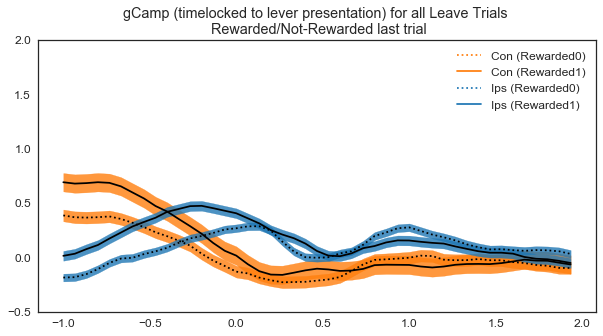

In [10]:
figure = plt.figure(figsize = (10, 5))
for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


    for r, r_st in zip([0, 1], [':', '-']):
        _g_reward = np.vstack(df_DMS[(df_DMS['Reward_last'] == r) & (df_DMS['Stay/Leave'] == 'stay') & (df_DMS['Action'] == ch)]['g_reward'])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(_g_reward, axis = 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)

        plt.plot(x, y, 'k', linestyle = r_st)
        plt.ylim([-0.5, 2.0])

        plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
        plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
plt.title('gCamp (timelocked to lever presentation) for all Leave Trials \n Rewarded/Not-Rewarded last trial')

plt.legend()


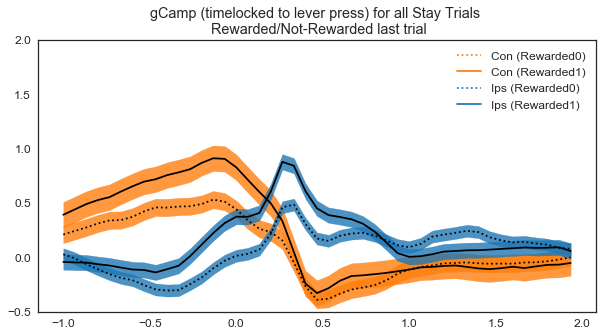

In [11]:
figure = plt.figure(figsize = (10, 5))
for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


    for r, r_st in zip([0, 1], [':', '-']):
        _g_reward = np.vstack(df_DMS[(df_DMS['Reward_last'] == r) & (df_DMS['Stay/Leave'] == 'stay') & (df_DMS['Action'] == ch)]['g_choice'])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(_g_reward, axis = 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)

        plt.plot(x, y, 'k', linestyle = r_st)
        plt.ylim([-0.5, 2.0])

        plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
        plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
plt.title('gCamp (timelocked to lever press) for all Stay Trials \n Rewarded/Not-Rewarded last trial')

plt.legend()


Double check that you have the alignment correct. 

You'll want: 

I was rewarded/not-rewarded last trial... 
I decided to stay/leave from last trial. 

I think I might have a one-off error for the gcamp-- I get the gcamp whether or not I am rewarded THIS trial. 

## use previous Q value difference to correlate with gcamp

In [12]:
import pickle
extract = pickle.load( open( "data/StanFit_int_pc.pickle", "rb" ) )
summary = pd.DataFrame.from_csv("data/summary_int_pc.csv")

# fncs for pulling out the actual alpha 

def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

# ## Save summary file.
# summary = fit2.summary()
# summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
# summary.to_csv(os.path.join('data/', 'summary_int_pc.csv'))

# # Save contents of StanFit.
# extract = fit2.extract()
# for k, v in standata.items(): extract[k] = v
# with open(os.path.join('data/' 'StanFit_int_pc.pickle'), 'wb') as fn: cPickle.dump(extract, fn)




In [13]:
%%time 
# get the predictions: 
N_samples = np.shape(extract['betas'])[0]


Q_i = np.zeros((N_samples, NS, (NT + 1)), float)
Q_c = np.zeros((N_samples, NS, (NT + 1)), float)
delta = np.zeros((N_samples, NS, NT), float)
Q_choice_saved = np.zeros((N_samples, NS, (NT + 1)), float)

for s in np.arange(NS):

    for t in np.arange(extract['NT_all'][s]):

        r_i = extract['r'][s, t]
        c_i = extract['c'][s, t]

        if c_i == 0: # contra choice
            Q_choice = Q_c; 
            Q_other = Q_i; 
        elif c_i == 1: # ipsa choice
            Q_choice = Q_i; 
            Q_other = Q_c; 
            
        delta[:, s, t] = r_i - Q_choice[:, s, t] 
        
        Q_choice_saved[:, s, t] = np.copy(Q_choice[:, s, t])
        # Q of the choice is updated, the other one is not. 
        Q_choice[:, s, t + 1] = Q_choice[:, s, t] + phi_approx(extract['alphas'][:,s]) * delta[:, s, t]
        Q_other[:, s, t + 1] = Q_other[: ,s, t]
        
        




_Q_i = np.mean(Q_i, 0)
_Q_c = np.mean(Q_c, 0)
Q_diff = (Q_c - Q_i)
_Q_diff = np.mean(Q_diff, 0)
_Q_choice = np.mean(Q_choice_saved, 0)

CPU times: user 43.8 s, sys: 14.6 s, total: 58.4 s
Wall time: 1min 10s


# putting the Q values and gcamp together

In [14]:
# putting the Q values and the gcamp together

_Q_diff_flat = np.zeros(sum(NT_all))
_Q_choice_flat = np.zeros(sum(NT_all))
for s in np.arange(NS):
    if s < 11:
        _Q_diff_flat[sum(NT_all[:s]) : sum(NT_all[:(s + 1)])] = (_Q_diff[s, :NT_all[s]])
        _Q_choice_flat[sum(NT_all[:s]) : sum(NT_all[:(s + 1)])] = (_Q_choice[s, :NT_all[s]])

    else: 
        _Q_diff_flat[sum(NT_all[:s]) : ] = (_Q_diff[s, :NT_all[s]])
        _Q_choice_flat[sum(NT_all[:s]) : sum(NT_all[:(s + 1)])] = (_Q_choice[s, :NT_all[s]])

    
df_trials['Q_diff'] = _Q_diff_flat
df_trials['Q_diff_last'] = df_trials['Q_diff'].groupby(df_trials['MouseID']).shift(1)
df_trials['Q_bef_choice'] = _Q_choice_flat

df_trials = df_trials.drop(['Q_diff'], axis = 1)



df_corr = pd.merge(df_DMS, df_trials[df_trials['RecordLoc'] == 1])
df_corr = df_corr.dropna(subset=['Q_diff_last'])
# (df_trials['RecordLoc'] == 1)
# df_DMS['Q_diff'] = df_DMS['Stay/Leave'].groupby(df_DMS['MouseID']).shift(-1)
# df_DMS['Reward_last'] = df_DMS['Reward'].groupby(df_DMS['MouseID']).shift(1)

Text(0,0.5,'Max GCaMP \n(timelocked to various times)')

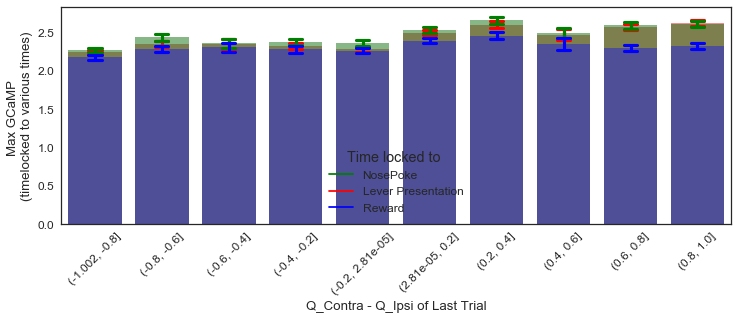

In [15]:
fig = plt.figure(figsize = (12, 4))
df_corr['bQ_diff_last'] = pd.cut(df_corr['Q_diff_last'], 10)
df_corr['max_np'] = [max(x) for x in df_corr['g_np']]
df_corr['max_lp'] = [max(x) for x in df_corr['g_lp']]
df_corr['max_r'] = [max(x) for x in df_corr['g_reward']]



plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')
sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'max_np', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'max_lp', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'max_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')

plt.xticks(rotation=45)
plt.xlabel('Q_Contra - Q_Ipsi of Last Trial')
plt.ylabel('Max GCaMP \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Max GCaMP \n(timelocked to various times)')

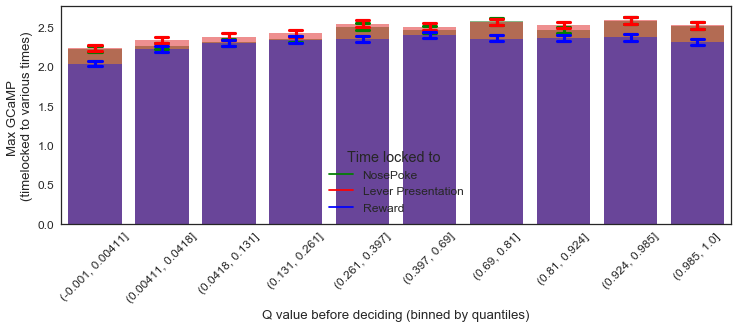

In [16]:
fig = plt.figure(figsize = (12, 4))
df_corr['bQ_bef_choice'] = pd.qcut(df_corr['Q_bef_choice'], 10)


plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')

sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'max_np', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'max_lp', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'max_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q value before deciding (binned by quantiles)')
plt.ylabel('Max GCaMP \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')

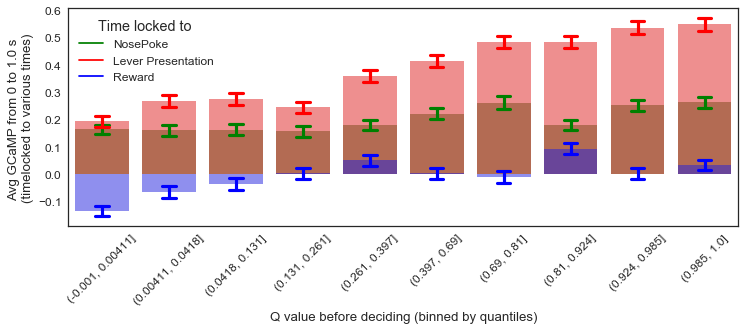

In [17]:
fig = plt.figure(figsize = (12, 4))
df_corr['avg_np'] = [np.mean(x[15:30], 0) for x in df_corr['g_np']]
df_corr['avg_lp'] = [np.mean(x[15:30], 0) for x in df_corr['g_lp']]
df_corr['avg_r'] = [np.mean(x[15:30], 0) for x in df_corr['g_reward']]

plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')

sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'avg_np', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'avg_lp', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_bef_choice', y = 'avg_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q value before deciding (binned by quantiles)')
plt.ylabel('Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')

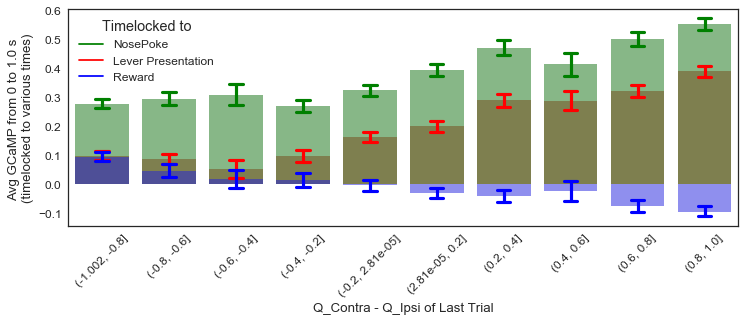

In [18]:
fig = plt.figure(figsize = (12, 4))



plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')

plt.legend(title = 'Timelocked to')

sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'avg_np', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'avg_lp', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'avg_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q_Contra - Q_Ipsi of Last Trial')
plt.ylabel('Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

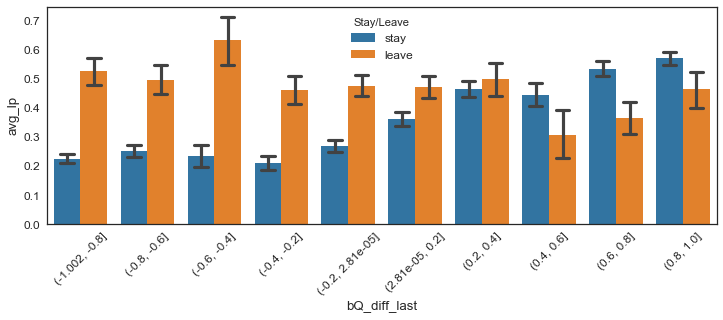

In [19]:
fig = plt.figure(figsize = (12, 4))

sns.barplot(data=df_corr, x = 'bQ_diff_last', y = 'avg_lp', ci = 68, capsize = 0.2,  hue = 'Stay/Leave')
plt.xticks(rotation=45)
# plt.xlabel('Q_Contra - Q_Ipsi of Last Trial')
# plt.ylabel('Avg GCaMP from 0 to 1.0 s \n(timelocked to Reward)')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

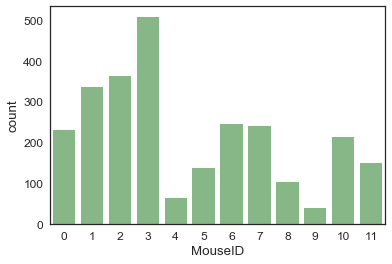

In [20]:
# sns.countplot(data = df_corr[df_corr['Q_diff_last'] < -0.8], x = 'MouseID', color = 'r', alpha = 0.5)
# sns.countplot(data = df_corr[df_corr['Q_diff_last'] > 0.8], x = 'MouseID', color = 'b', alpha = 0.5)
sns.countplot(data = df_corr[(df_corr['Q_diff_last'] > -0.2) & (df_corr['Q_diff_last'] < 0.2)], x = 'MouseID', color = 'g', alpha = 0.5)


np.unique(df_corr[df_corr['Q_diff_last'] < -0.8].MouseID)

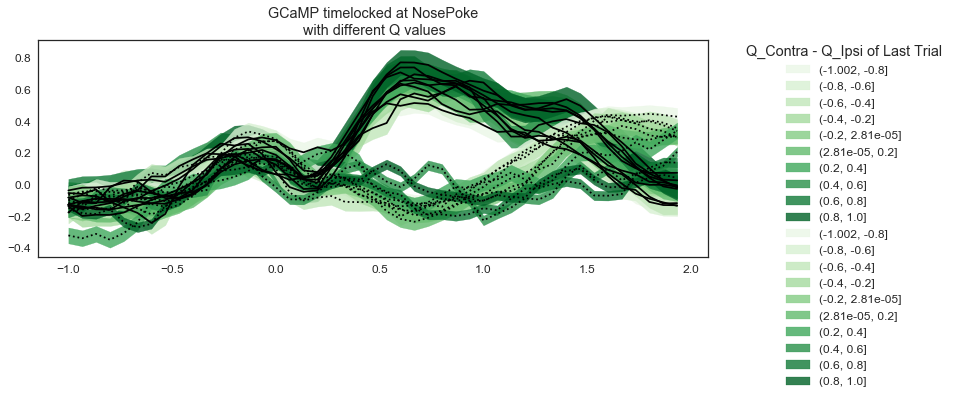

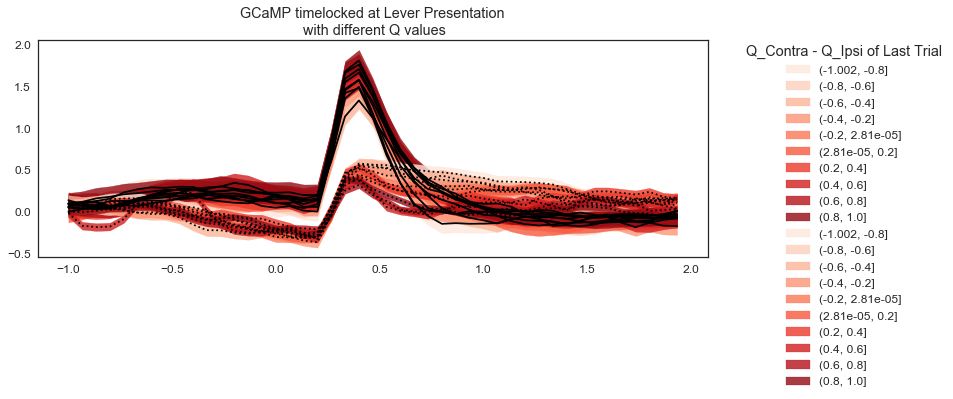

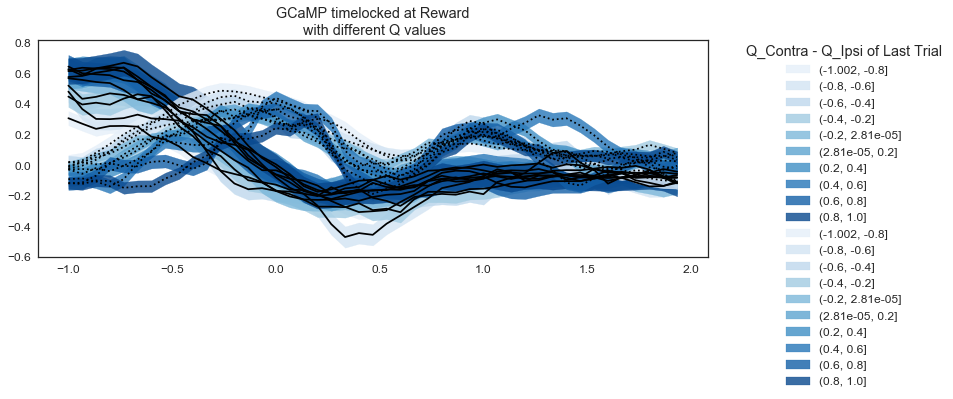

In [21]:
# if True:

for timelocked, tl_name, palette in zip(['g_np', 'g_lp', 'g_reward'], ['NosePoke', 'Lever Presentation', 'Reward'], ['Greens', 'Reds','Blues']):
    figure = plt.figure(figsize=(12, 4))

    for act, line_type in zip(['Con', 'Ips'], ['-', ':']):
        df_src = df_corr[df_corr['Action'] == act]


        qlims = np.unique(df_src['bQ_diff_last'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_diff_last'] > q_i.left) & (df_src['Q_diff_last'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = line_type)

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n with different Q values')
        plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



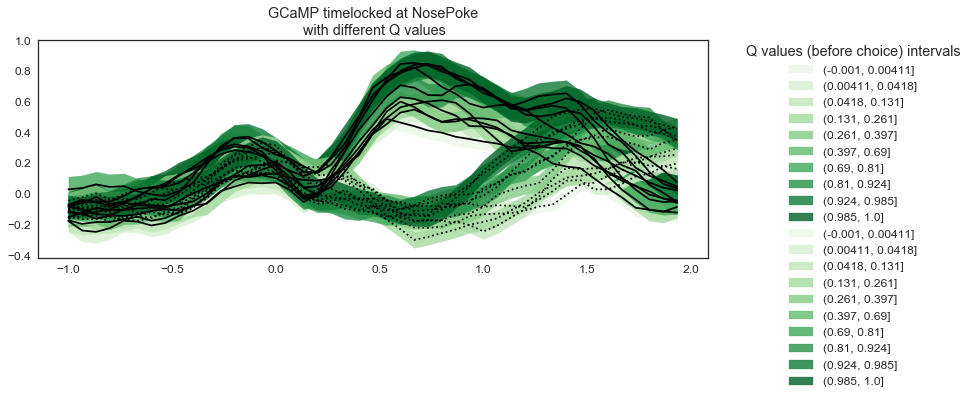

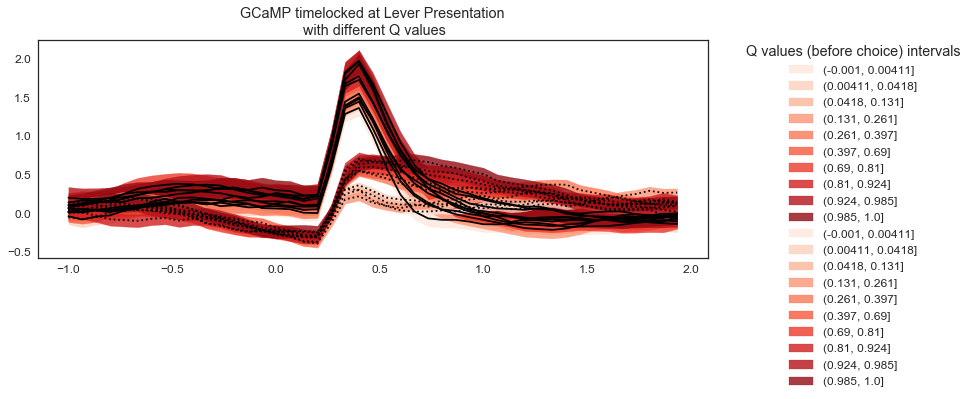

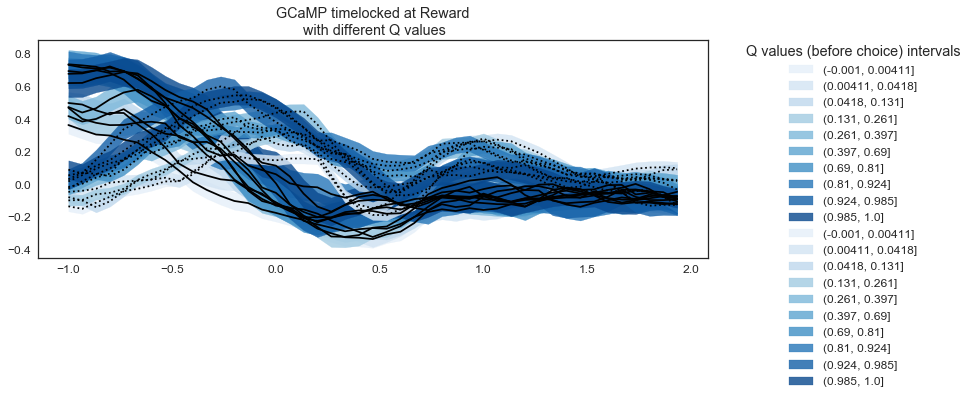

In [22]:

for timelocked, tl_name, palette in zip(['g_np', 'g_lp', 'g_reward'], ['NosePoke', 'Lever Presentation', 'Reward'], ['Greens', 'Reds','Blues']):
    figure = plt.figure(figsize=(12, 4))

    for act, line_type in zip(['Con', 'Ips'], ['-', ':']):
        df_src = df_corr[df_corr['Action'] == act]

        qlims = np.unique(df_src['bQ_bef_choice'].dropna())

        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_bef_choice'] > q_i.left) & (df_src['Q_bef_choice'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = line_type)

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n with different Q values')
        plt.legend(title = 'Q values (before choice) intervals', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

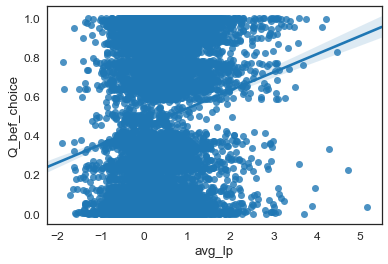

In [23]:
sns.regplot(data = df_corr, y = 'Q_bef_choice', x = 'avg_lp') # , hue = 'Action') #, x_estimator = np.round)
